In [1]:
import os.path
os.chdir("/scratch/users/sheetal/ProtTrans/Fine-Tuning")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
!pip install umap-learn
import umap

2024-02-08 10:28:39.973170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 10:28:42.710896: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 10:28:47.586168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-08 10:28:47.586567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [3]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.2
Pandas version:  2.1.3
Transformers version:  4.35.2
Datasets version:  2.15.0


In [4]:
from Bio import SeqIO
import pandas as pd

local_fasta_path = './train_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q9UQC2|GAB2_HUMAN%598%614,SGTNSPAPKKSTGSVDYLALDFQPSSPSPHRKP,1
1,sp|P18031|PTN1_HUMAN%137%153,DTNLKLTLISEDIKSYYTVRQLELENLTTQETR,1
2,sp|P08581|MET_HUMAN%1340%1356,IFSTFIGEHYVHVNATYVNVKCVAPYPSLLSSE,1
3,sp|P35968|VGFR2_HUMAN%980%996,EKSLSDVEEEEAPEDLYKDFLTLEHLICYSFQV,1
4,sp|P35568|IRS1_HUMAN%880%896,QQQPLLHPPEPKSPGEYVNIEFGSDQSGYLSGP,1


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(160, 2)

Validation Set:
(41, 2)


In [6]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [7]:
class ClassConfig:
    def __init__(self, dropout=0.9, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [8]:
def PT5_classification_model(num_labels):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50") 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig()
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [9]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [10]:
from sklearn.metrics import accuracy_score
!pip install seaborn
import seaborn as sns

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset
    
# Main training fuction
def train_per_protein(
        train_df,         #training data
        valid_df,         #validation data      
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs= 10,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed= True,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1 ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Add spaces between each amino acid for PT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

    def apply_umap(embeddings, n_components=2, min_dist=0.01):
        umap_model = umap.UMAP(n_components=n_components)
        umap_embeddings = umap_model.fit_transform(embeddings)
        return umap_embeddings

    def plot_umap(embeddings, labels):
        data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
        df = pd.DataFrame(data)
    
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette="flare", s=50, alpha=0.9)
        plt.title("UMAP Visualization of Embeddings")
        plt.savefig(f"./Plots/Dephospho/UMAP_Visualization_of_Embeddings.pdf")
        plt.show()
        
    # Train model
    trainer.train()

    valid_sequences = list(valid_df['sequence'])
    valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

    # Apply UMAP for dimensionality reduction
    umap_embeddings = apply_umap(valid_embeddings)

    # Plot UMAP embeddings
    labels = list(valid_df['label'])
    plot_umap(umap_embeddings, labels)

    return tokenizer, model, trainer.state.log_history


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ProtT5_Classfier
Trainable Parameter: 1209193474
ProtT5_LoRA_Classfier
Trainable Parameter: 3559426

[2024-02-08 10:31:55,405] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2024-02-08 10:31:56,584] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-02-08 10:31:56,586] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


 [WARNING]  cpu_adam cuda is missing or is incompatible with installed torch, only cpu ops can be compiled!


Using /home/centos/.cache/torch_extensions/py39_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/centos/.cache/torch_extensions/py39_cu121/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/4] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=cpu_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/scratch/users/anup/miniconda3/envs/test_new/lib/python3.9/site-packages/deepspeed/ops/csrc/includes -I/usr/local/cuda/include -isystem /scratch/users/anup/miniconda3/envs/test_new/lib/python3.9/site-packages/torch/include -isystem /scratch/users/anup/miniconda3/envs/test_new/lib/python3.9/site-packages/torch/include/torch/csrc/api/include -isystem /scratch/users/anup/miniconda3/envs/test_new/lib/python3.9/site-packages/torch/include/TH -isystem /scratch/users/anup/miniconda3/envs/test_new/lib/python3.9/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /scratch/users/anup/miniconda3/envs/test_new/include/python3.9 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ 

Loading extension module cpu_adam...
/scratch/users/anup/miniconda3/envs/test_new/lib/python3.9/site-packages/deepspeed/runtime/zero/stage_1_and_2.py:1221: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  total_norm_cuda = get_accelerator().FloatTensor([float(total_norm)])


Epoch,Training Loss,Validation Loss,Accuracy
1,0.723000,0.683840,0.560976
2,0.698600,0.671040,0.756098
3,0.676200,0.660624,0.707317
4,0.690400,0.651119,0.707317
5,0.645700,0.638168,0.731707
6,0.638300,0.622842,0.756098
7,0.602100,0.604928,0.756098
8,0.587400,0.573585,0.780488
9,0.588000,0.534199,0.756098
10,0.558100,0.502594,0.756098


Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


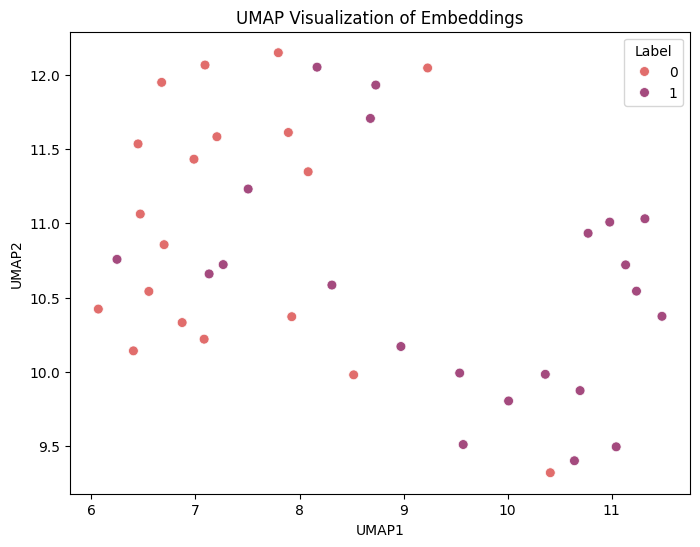

In [11]:
tokenizer, model, history = train_per_protein(my_train, my_valid, num_labels=2, batch=1, accum=8, epochs=20, seed=42)

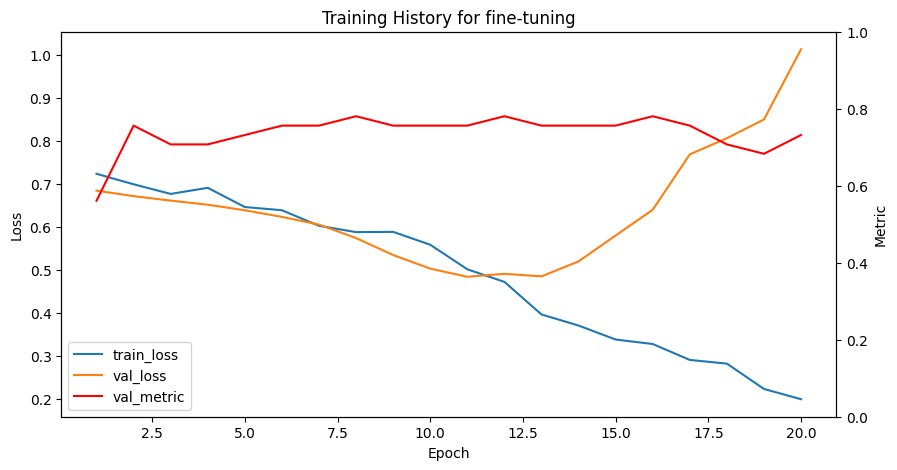

In [12]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs, metric, color='red', label='val_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"./Plots/Dephospho/Training_History_for_fine-tuning.pdf")
plt.show()

In [13]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [14]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

save_model(model, "./my_finetuned.pth")

In [15]:
tokenizer, model_reload = load_model("./my_finetuned.pth", num_labels=2)

ProtT5_Classfier
Trainable Parameter: 1209193474
ProtT5_LoRA_Classfier
Trainable Parameter: 3559426



In [16]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [17]:
from Bio import SeqIO
import pandas as pd

local_fasta_path = './test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P20963|CD3Z_HUMAN%126%142,IGMKGERRRGKGHDGLYQGLSTATKDTYDALHM,1
1,sp|P00533|EGFR_HUMAN%1076%1092,ALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNP,1
2,sp|P08581|MET_HUMAN%1349%1365,YVHVNATYVNVKCVAPYPSLLSSEDNADDEVDT,1
3,sp|P09619|PGFRB_HUMAN%841%857,KICDFGLARDIMRDSNYISKGSTFLPLKWMAPE,1
4,sp|Q13480|GAB1_HUMAN%573%589,VHSTTSSSDSHDSEENYVPMNPNLSSEDPNLFG,1


In [18]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  IGMKGERRRGKGHDGLYQGLSTATKDTYDALHM      1
1  ALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNP      1
2  YVHVNATYVNVKCVAPYPSLLSSEDNADDEVDT      1
3  KICDFGLARDIMRDSNYISKGSTFLPLKWMAPE      1
4  VHSTTSSSDSHDSEENYVPMNPNLSSEDPNLFG      1


In [19]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.682692 |      0.807692 |         0.875 |       0.84 |  0.913462 |
+----------+---------------+---------------+------------+-----------+
[[21  5]
 [ 3 21]]


(160, 1024)
(41, 1024)
(50, 1024)

Training Loop 1
Epoch 1/20
20/20 [==============================] - 3s 47ms/step - loss: 0.7268 - accuracy: 0.4500 - auc_roc: 0.4928 - val_loss: 0.7255 - val_accuracy: 0.4146 - val_auc_roc: 0.5622
Epoch 2/20
20/20 [==============================] - 0s 23ms/step - loss: 0.6636 - accuracy: 0.6250 - auc_roc: 0.6271 - val_loss: 0.6620 - val_accuracy: 0.6098 - val_auc_roc: 0.6806
Epoch 3/20
20/20 [==============================] - 0s 24ms/step - loss: 0.6234 - accuracy: 0.6125 - auc_roc: 0.7316 - val_loss: 0.6518 - val_accuracy: 0.6098 - val_auc_roc: 0.7069
Epoch 4/20
20/20 [==============================] - 1s 30ms/step - loss: 0.6154 - accuracy: 0.6687 - auc_roc: 0.7453 - val_loss: 0.6446 - val_accuracy: 0.6341 - val_auc_roc: 0.7273
Epoch 5/20
20/20 [==============================] - 1s 30ms/step - loss: 0.5738 - accuracy: 0.7625 - auc_roc: 0.8175 - val_loss: 0.6300 - val_accuracy: 0.6098 - val_auc_roc: 0.7392
Epoch 6/20
20/20 [==========================

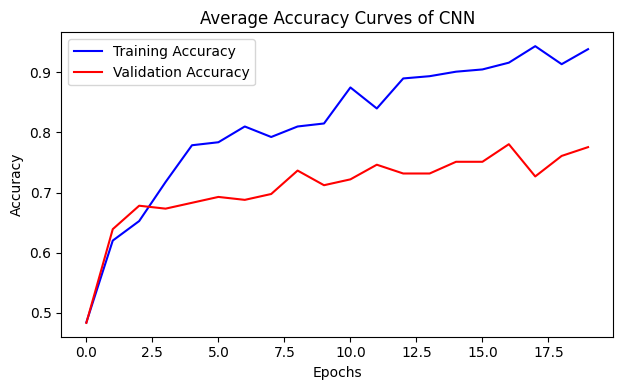

2/2 [==============================] - 0s 7ms/step
[0.9123984  0.31517586 0.3210657  0.9078947  0.6642841  0.46211943
 0.88573194 0.8771853  0.8940529  0.5081898  0.4022175  0.9455651
 0.9082818  0.438389   0.40960056 0.91445017 0.44156212 0.8988051
 0.9450294  0.92083883 0.39568657 0.4383381  0.55696076 0.49415794
 0.41452578 0.34311873 0.3495957  0.40070757 0.43767205 0.4080978
 0.38832158 0.2006963  0.42958534 0.28921798 0.31403616 0.33650413
 0.42496893 0.5554036  0.27732334 0.4187464  0.5875454  0.23537196
 0.30607313 0.34781334 0.34906256 0.44470644 0.24921747 0.3483047
 0.39877012 0.44553265]
╒═════════════╤══════════╕
│ Metric      │    Value │
╞═════════════╪══════════╡
│ Accuracy    │ 0.76     │
├─────────────┼──────────┤
│ AUC         │ 0.753205 │
├─────────────┼──────────┤
│ Sensitivity │ 0.583333 │
├─────────────┼──────────┤
│ Specificity │ 0.923077 │
├─────────────┼──────────┤
│ MCC         │ 0.54237  │
╘═════════════╧══════════╛


In [27]:
from torch.utils.data import Dataset
from keras.models import Sequential
from keras.layers import Embedding, Lambda, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Reshape
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import h5py
from sklearn.utils.class_weight import compute_class_weight


def plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()



def load_embeddings(h5_path):
    with h5py.File(h5_path, 'r') as hf:
        embeddings = hf['embedding'][:]
    return embeddings


train_embeddings = load_embeddings("./embeddings/data_train.h5")
valid_embeddings = load_embeddings("./embeddings/data_valid.h5")
test_embeddings = load_embeddings("./embeddings/data_test.h5")
 

def CNN_model(input_sequence_length):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=16, activation='relu', kernel_initializer='he_normal', input_shape=(input_sequence_length, 1)))
    model.add(Dropout(0.05))       
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.05))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(1, activation='sigmoid'))

    return model



pre_train_Y_CNN_labels = np.array(my_train['label'])
pre_valid_Y_CNN_labels = np.array(my_valid['label'])

n_epo_cnn = 20
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]




train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], train_embeddings.shape[1])
print(train_embeddings.shape)

# valid_embeddings has a shape of (40, 1024)
valid_embeddings = valid_embeddings.reshape(valid_embeddings.shape[0], valid_embeddings.shape[1])
print(valid_embeddings.shape)

print(test_embeddings.shape)

# Create the CNN model with the correct input shape
input_sequence_length = train_embeddings.shape[1]


#print("Shape of pre_train_ST_CNN:", pre_train_ST_CNN.shape)
#print("Shape of pre_valid_ST_CNN:", pre_valid_ST_CNN.shape)



all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

max_len = 0
saved_results_list = []

for i in range(5):
    print(f"\nTraining Loop {i + 1}")

    model_cnn = CNN_model(input_sequence_length)
    model_cnn.compile(optimizer=Adam(learning_rate=1e-5), loss=BinaryCrossentropy(), metrics=metrics)

    checkpointer = ModelCheckpoint(filepath="./pre_model_cnn.h5", 
                                monitor="val_accuracy",
                                verbose=0,
                                save_weights_only=True,
                                save_best_only=True)

    
    # Train the model using loaded embeddings
    pre_history_A = model_cnn.fit(train_embeddings, pre_train_Y_CNN_labels, batch_size=8, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
                            validation_data=(valid_embeddings, pre_valid_Y_CNN_labels))

    

    all_train_losses.append(pre_history_A.history['loss'])
    all_train_accuracies.append(pre_history_A.history['accuracy'])
    all_val_losses.append(pre_history_A.history['val_loss'])
    all_val_accuracies.append(pre_history_A.history['val_accuracy'])

    # Save the results after each loop
    saved_results = {
        'train_losses': all_train_losses.copy(),
        'train_accuracies': all_train_accuracies.copy(),
        'val_losses': all_val_losses.copy(),
        'val_accuracies': all_val_accuracies.copy()
    }
    saved_results_list.append(saved_results)
    np.save(f'saved_results_loop_{i + 1}.npy', saved_results)

    max_len = max(max_len, len(all_train_losses[-1])) #since arrays within the list are not of same shape, so making the length of the lists as same


for result in saved_results_list:
    for key in result:
        result[key] = [np.pad(lst, (0, max_len - len(lst))) for lst in result[key]]


# Trim or zero-pad the lists to the maximum length
all_train_losses = [lst[:max_len] for lst in all_train_losses]
all_train_accuracies = [lst[:max_len] for lst in all_train_accuracies]
all_val_losses = [lst[:max_len] for lst in all_val_losses]
all_val_accuracies = [lst[:max_len] for lst in all_val_accuracies]

# Take the average of saved results
avg_train_loss = np.mean(all_train_losses, axis=0)
avg_train_accuracy = np.mean(all_train_accuracies, axis=0)
avg_val_loss = np.mean(all_val_losses, axis=0)
avg_val_accuracy = np.mean(all_val_accuracies, axis=0)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracy, label='Training Accuracy', color='blue')
plt.plot(avg_val_accuracy, label='Validation Accuracy', color='red')
plt.title('Average Accuracy Curves of CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.savefig(f"./Plots/Dephospho/cnn_with_embedding.pdf")
plt.show()

pre_test_Y_CNN_labels = np.array(my_test['label'])




loaded_model_cnn = CNN_model(input_sequence_length)  
loaded_model_cnn.load_weights("./pre_model_cnn.h5")
y_pred_cnn = loaded_model_cnn.predict(test_embeddings).reshape(pre_test_Y_CNN_labels.shape[0],)

print(y_pred_cnn)
y_pred_cnn = (y_pred_cnn > 0.5)
y_pred_cnn = [int(i) for i in y_pred_cnn]
pre_test_Y_CNN_labels = np.array(pre_test_Y_CNN_labels)
y_pred_cnn = np.array(y_pred_cnn)



# Evaluate CNN model on test set
cm_cnn = confusion_matrix(pre_test_Y_CNN_labels, y_pred_cnn)
mcc_cnn = matthews_corrcoef(pre_test_Y_CNN_labels, y_pred_cnn)
acc_cnn = accuracy_score(pre_test_Y_CNN_labels, y_pred_cnn)
roc_auc_cnn = roc_auc_score(pre_test_Y_CNN_labels, y_pred_cnn)

sn_cnn = cm_cnn[1][1] / (cm_cnn[1][1] + cm_cnn[1][0])
sp_cnn = cm_cnn[0][0] / (cm_cnn[0][0] + cm_cnn[0][1])

#plot(pre_history_A)


table_data = [
    ["Metric", "Value"],
    ["Accuracy", str(acc_cnn)],
    ["AUC", str(roc_auc_cnn)],
    ["Sensitivity", str(sn_cnn)],
    ["Specificity", str(sp_cnn)],
    ["MCC", str(mcc_cnn)],
]

print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))


In [21]:
print(test_embeddings.shape, pre_test_Y_CNN_labels.shape, np.array(my_test['label']).shape)

(50, 1024) (50,) (50,)


In [22]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
import pandas as pd
import tqdm
import h5py
from Bio import SeqIO
from sklearn.utils import shuffle


# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, LSTM, Dropout, Bidirectional, GRU, SpatialDropout1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax

from keras import backend as K
from keras.backend import expand_dims
from keras.regularizers import l1, l2

from tensorflow.keras import backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input


(160, 33)
(41, 33)
(50, 33)
(160,)
(41,)

Training Loop 1
Epoch 1/20
5/5 [==============================] - 1s 102ms/step - loss: 0.6931 - accuracy: 0.5000 - auc_roc: 0.5351 - val_loss: 0.6929 - val_accuracy: 0.4390 - val_auc_roc: 0.5849
Epoch 2/20
5/5 [==============================] - 0s 28ms/step - loss: 0.6916 - accuracy: 0.5312 - auc_roc: 0.5565 - val_loss: 0.6925 - val_accuracy: 0.4634 - val_auc_roc: 0.5909
Epoch 3/20
5/5 [==============================] - 0s 28ms/step - loss: 0.6913 - accuracy: 0.5500 - auc_roc: 0.5742 - val_loss: 0.6917 - val_accuracy: 0.4878 - val_auc_roc: 0.5897
Epoch 4/20
5/5 [==============================] - 0s 24ms/step - loss: 0.6891 - accuracy: 0.5875 - auc_roc: 0.6179 - val_loss: 0.6911 - val_accuracy: 0.4878 - val_auc_roc: 0.6065
Epoch 5/20
5/5 [==============================] - 0s 20ms/step - loss: 0.6881 - accuracy: 0.6250 - auc_roc: 0.6840 - val_loss: 0.6907 - val_accuracy: 0.4878 - val_auc_roc: 0.6089
Epoch 6/20
5/5 [==============================

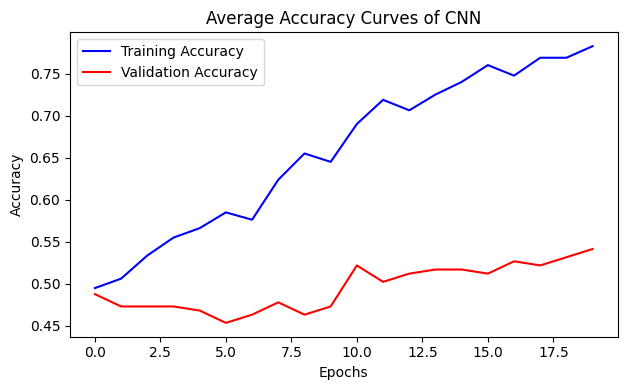

2/2 [==============================] - 0s 5ms/step
(50,)
╒═════════════╤══════════╕
│ Metric      │    Value │
╞═════════════╪══════════╡
│ Accuracy    │ 0.54     │
├─────────────┼──────────┤
│ AUC         │ 0.557692 │
├─────────────┼──────────┤
│ Sensitivity │ 1        │
├─────────────┼──────────┤
│ Specificity │ 0.115385 │
├─────────────┼──────────┤
│ MCC         │ 0.242734 │
╘═════════════╧══════════╛


In [49]:
#CNN with sequences
   
def get_encoding(csv_file, sequence):
    # This is returning just integers to feed to the embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    data = pd.read_csv(csv_file)
    sequences = data[sequence].tolist()
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq if char in alphabet]
        except:
            continue
        encodings.append(integer_encoded)
        
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings

def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(128, kernel_size=(16, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.02))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=(8, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.02))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.02))
    model.add(Dense(1, activation='sigmoid'))
    return model

pre_train_Y_CNN = get_encoding('./my_train.csv', 'sequence')
pre_valid_Y_CNN = get_encoding('./my_valid.csv', 'sequence')
pre_test_Y_CNN = get_encoding('./my_test.csv', 'sequence')

pre_train_Y_CNN_labels = np.array(my_train['label'])
print(pre_train_Y_CNN_labels.shape)
pre_valid_Y_CNN_labels = np.array(my_valid['label'])
print(pre_valid_Y_CNN_labels.shape)


n_epo_cnn = 20
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]


all_train_losses_cnn = []
all_train_accuracies_cnn = []
all_val_losses_cnn = []
all_val_accuracies_cnn = []

max_len_cnn = 0
saved_results_list_cnn = []

for i in range(5):
    print(f"\nTraining Loop {i + 1}")

    model_A = CNN_model()
    model_A.compile(optimizer=Adam(learning_rate=1e-5), loss=BinaryCrossentropy(), metrics=metrics)

    checkpointer = ModelCheckpoint(filepath="./pre_model_A.h5", 
                                monitor="val_accuracy",
                                verbose=0,
                                save_weights_only=True,
                                save_best_only=True)

    
    # Train the model using loaded embeddings
    pre_history = model_A.fit(pre_train_Y_CNN, pre_train_Y_CNN_labels, batch_size=32, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
                            validation_data=(pre_valid_Y_CNN, pre_valid_Y_CNN_labels))

    

    all_train_losses_cnn.append(pre_history.history['loss'])
    all_train_accuracies_cnn.append(pre_history.history['accuracy'])
    all_val_losses_cnn.append(pre_history.history['val_loss'])
    all_val_accuracies_cnn.append(pre_history.history['val_accuracy'])

    # Save the results after each loop
    saved_results = {
        'train_losses': all_train_losses_cnn.copy(),
        'train_accuracies': all_train_accuracies_cnn.copy(),
        'val_losses': all_val_losses_cnn.copy(),
        'val_accuracies': all_val_accuracies_cnn.copy()
    }
    saved_results_list_cnn.append(saved_results)
    np.save(f'saved_results_loop_{i + 1}.npy', saved_results)

    max_len_cnn = max(max_len_cnn, len(all_train_losses_cnn[-1])) #since arrays within the list are not of same shape, so making the length of the lists as same


for result in saved_results_list_cnn:
    for key in result:
        result[key] = [np.pad(lst, (0, max_len_cnn - len(lst))) for lst in result[key]]


# Trim or zero-pad the lists to the maximum length
all_train_losses_cnn = [lst[:max_len_cnn] for lst in all_train_losses_cnn]
all_train_accuracies_cnn = [lst[:max_len_cnn] for lst in all_train_accuracies_cnn]
all_val_losses_cnn = [lst[:max_len_cnn] for lst in all_val_losses_cnn]
all_val_accuracies_cnn = [lst[:max_len_cnn] for lst in all_val_accuracies_cnn]

# Take the average of saved results
avg_train_loss = np.mean(all_train_losses_cnn, axis=0)
avg_train_accuracy = np.mean(all_train_accuracies_cnn, axis=0)
avg_val_loss = np.mean(all_val_losses_cnn, axis=0)
avg_val_accuracy = np.mean(all_val_accuracies_cnn, axis=0)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracy, label='Training Accuracy', color='blue')
plt.plot(avg_val_accuracy, label='Validation Accuracy', color='red')
plt.title('Average Accuracy Curves of CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.savefig(f"./Plots/Dephospho/cnn_with_sequences.pdf")
plt.show()

loaded_model_A = CNN_model()
loaded_model_A.load_weights("./pre_model_A.h5")
y_pred = loaded_model_A.predict(pre_test_Y_CNN).reshape(pre_test_Y_CNN_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_Y_CNN_labels = np.array(my_test['label'])
print(pre_test_Y_CNN_labels.shape)
y_pred = np.array(y_pred)


# Evaluate CNN model on test set
cm_cnn = confusion_matrix(pre_test_Y_CNN_labels, y_pred)
mcc_cnn = matthews_corrcoef(pre_test_Y_CNN_labels, y_pred)
acc_cnn = accuracy_score(pre_test_Y_CNN_labels, y_pred)
roc_auc_cnn = roc_auc_score(pre_test_Y_CNN_labels, y_pred)

sn_cnn = cm_cnn[1][1] / (cm_cnn[1][1] + cm_cnn[1][0])
sp_cnn = cm_cnn[0][0] / (cm_cnn[0][0] + cm_cnn[0][1])

#plot(pre_history)


table_data = [
    ["Metric", "Value"],
    ["Accuracy", str(acc_cnn)],
    ["AUC", str(roc_auc_cnn)],
    ["Sensitivity", str(sn_cnn)],
    ["Specificity", str(sp_cnn)],
    ["MCC", str(mcc_cnn)],
]

print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))


(160, 33)
(160,)
(41, 33)
(41,)
PRE Training Transformer model...

Training Loop 1
Epoch 1/20
40/40 [==============================] - 6s 43ms/step - loss: 0.7695 - accuracy: 0.5500 - auc_roc: 0.5749 - val_loss: 0.6713 - val_accuracy: 0.5366 - val_auc_roc: 0.7093
Epoch 2/20
40/40 [==============================] - 1s 16ms/step - loss: 0.6882 - accuracy: 0.5312 - auc_roc: 0.5737 - val_loss: 0.6536 - val_accuracy: 0.6341 - val_auc_roc: 0.6878
Epoch 3/20
40/40 [==============================] - 1s 15ms/step - loss: 0.6285 - accuracy: 0.6750 - auc_roc: 0.7169 - val_loss: 0.6372 - val_accuracy: 0.5854 - val_auc_roc: 0.6758
Epoch 4/20
40/40 [==============================] - 1s 17ms/step - loss: 0.6013 - accuracy: 0.6938 - auc_roc: 0.7436 - val_loss: 0.8409 - val_accuracy: 0.4878 - val_auc_roc: 0.6770
Epoch 5/20
40/40 [==============================] - 1s 14ms/step - loss: 0.5998 - accuracy: 0.6750 - auc_roc: 0.7395 - val_loss: 0.7705 - val_accuracy: 0.5854 - val_auc_roc: 0.6902
Epoch 6/20
4

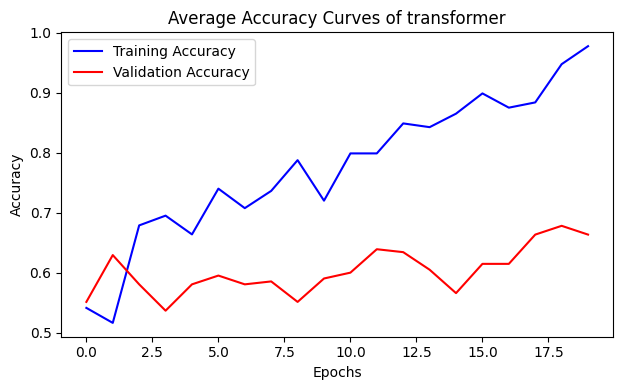

(50, 33)
(50,)
2/2 [==============================] - 0s 7ms/step
╒═════════════╤══════════╕
│ Metric      │    Value │
╞═════════════╪══════════╡
│ Accuracy    │ 0.6      │
├─────────────┼──────────┤
│ AUC         │ 0.615385 │
├─────────────┼──────────┤
│ Sensitivity │ 1        │
├─────────────┼──────────┤
│ Specificity │ 0.230769 │
├─────────────┼──────────┤
│ MCC         │ 0.354787 │
╘═════════════╧══════════╛
[[ 6 20]
 [ 0 24]]


In [59]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.01):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(2 * ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


def transformer_model():
    vocab_size = 21
    embed_dim = 128 #config["embedding_dim"]
    ff_dim = 128 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.01 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) 
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])


n_epo_transformer = 20
metrics1 = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]


print(pre_train_Y_CNN.shape)
print(pre_train_Y_CNN_labels.shape)
print(pre_valid_Y_CNN.shape)
print(pre_valid_Y_CNN_labels.shape)



all_train_losses2 = []
all_train_accuracies2 = []
all_val_losses2 = []
all_val_accuracies2 = []

max_len2 = 0

print("PRE Training Transformer model...")

saved_results_list2 = []

for i in range(5):
    print(f"\nTraining Loop {i + 1}")

    model_transformer = transformer_model()
    model_transformer.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics1)
    
    checkpointer = ModelCheckpoint(filepath="./pre_model_transformer.h5",
                                    monitor = "val_accuracy",
                                    verbose = 0,
                                    save_weights_only=True,
                                    save_best_only=True)
    
    pre_history = model_transformer.fit(pre_train_Y_CNN, pre_train_Y_CNN_labels, batch_size=4, epochs=n_epo_transformer, verbose=1, callbacks=[checkpointer],
        validation_data=(pre_valid_Y_CNN, pre_valid_Y_CNN_labels))

    all_train_losses2.append(pre_history.history['loss'])
    all_train_accuracies2.append(pre_history.history['accuracy'])
    all_val_losses2.append(pre_history.history['val_loss'])
    all_val_accuracies2.append(pre_history.history['val_accuracy'])

    saved_results2 = {
        'train_losses': all_train_losses2.copy(),
        'train_accuracies': all_train_accuracies2.copy(),
        'val_losses': all_val_losses2.copy(),
        'val_accuracies': all_val_accuracies2.copy()
    }
    saved_results_list2.append(saved_results2)
    np.save(f'saved_results_Transformerloop_{i + 1}.npy', saved_results2)

    max_len2 = max(max_len2, len(all_train_losses2[-1]))


for result in saved_results_list2:
    for key in result:
        result[key] = [np.pad(lst, (0, max_len2 - len(lst))) for lst in result[key]]


# Trim or zero-pad the lists to the maximum length
all_train_losses2 = [lst[:max_len2] for lst in all_train_losses2]
all_train_accuracies2 = [lst[:max_len2] for lst in all_train_accuracies2]
all_val_losses2 = [lst[:max_len2] for lst in all_val_losses2]
all_val_accuracies2 = [lst[:max_len2] for lst in all_val_accuracies2]

# Take the average of saved results
avg_train_loss = np.mean(all_train_losses2, axis=0)
avg_train_accuracy = np.mean(all_train_accuracies2, axis=0)
avg_val_loss = np.mean(all_val_losses2, axis=0)
avg_val_accuracy = np.mean(all_val_accuracies2, axis=0)


# Plot average curves
plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracy, label='Training Accuracy', color='blue')
plt.plot(avg_val_accuracy, label='Validation Accuracy', color='red')
plt.title('Average Accuracy Curves of transformer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/Dephospho/Average_Accuracy_Curves_of_transformer.pdf")
plt.show()

print(pre_test_Y_CNN.shape)
print(pre_test_Y_CNN_labels.shape)

loaded_model_transformer = transformer_model()
loaded_model_transformer.load_weights("./pre_model_transformer.h5")


y_pred = loaded_model_transformer.predict(pre_test_Y_CNN).reshape(pre_test_Y_CNN_labels.shape[0],)

y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
y_pred = np.array(y_pred)


cm_transformer = confusion_matrix(pre_test_Y_CNN_labels, y_pred)
mcc_transformer = matthews_corrcoef(pre_test_Y_CNN_labels, y_pred)
acc_transformer = accuracy_score(pre_test_Y_CNN_labels, y_pred)
roc_auc_transformer = roc_auc_score(pre_test_Y_CNN_labels, y_pred)

sn_transformer = cm_transformer[1][1]/(cm_transformer[1][1]+cm_transformer[1][0])
sp_transformer = cm_transformer[0][0]/(cm_transformer[0][0]+cm_transformer[0][1])

#plot(pre_history)

table_data_transformer = [
    ["Metric", "Value"],
    ["Accuracy", str(acc_transformer)],
    ["AUC", str(roc_auc_transformer)],
    ["Sensitivity", str(sn_transformer)],
    ["Specificity", str(sp_transformer)],
    ["MCC", str(mcc_transformer)],
]

# Print the table
print(tabulate(table_data_transformer, headers="firstrow", tablefmt="fancy_grid"))

print(cm_transformer)
